In [1]:
!pip install pydicom

In [2]:
!pip install seaborn

In [20]:
import pandas as pd                              # `pandas` to handle `dataframes`

from os import listdir                           # `os` to handle `directories`
from os.path import isfile, join

import matplotlib.pylab as plt                   # `matplotlib` for `image visualization`
from matplotlib.patches import Rectangle

import pydicom as pdm                            # `pydicom` to open `DICOM files`

import seaborn as sns                            # `seaborn` for `data distribution visualization`

import cv2                                       # `cv2` to handle `images`

In [21]:
import warnings
warnings.filterwarnings('ignore')

In [22]:
!pwd

/home/jupyter/home/task1_rsna_pneumonia


In [23]:
WORK_DIR = '/home/jupyter/home/task1_rsna_pneumonia/'

# I. Load and Verify Data

## A. `DICOM` Data

In [15]:
DATA_DIR = WORK_DIR + 'data/'
TRAIN_IMG_DIR = WORK_DIR + 'data/stage_2_train_images/'
TEST_IMG_DIR = WORK_DIR + 'data/stage_2_test_images/'

### `DICOM` Files: Load, Check Size

In [16]:
train_images = [f for f in listdir(TRAIN_IMG_DIR) if isfile(join(TRAIN_IMG_DIR, f))]
test_images = [f for f in listdir(TEST_IMG_DIR) if isfile(join(TEST_IMG_DIR, f))]

In [17]:
len(train_images), train_images[:5]

(26684,
 ['601eaa5d-3e4d-4d4c-b7df-600eb953554d.dcm',
  '31694f91-f16d-4d5c-9dac-b5c7dd5c767d.dcm',
  'cc3e8735-8a48-4704-a79e-a253677ee5f9.dcm',
  '4399092c-0489-4ec7-97a5-fbffd3da0ea6.dcm',
  '6c6483ba-b672-402d-8d8a-10452b1e1387.dcm'])

In [18]:
len(test_images), test_images[:5]

(3000,
 ['0cef9e32-622e-4703-80e1-c14460e9f716.dcm',
  '2e34e10c-62b2-48b0-bd44-ccb690b3f461.dcm',
  '032b9367-1ce3-44e8-9b74-8f3e2203e8ec.dcm',
  '0483d8c8-2d15-4ae0-8034-4dca932e8ddd.dcm',
  '20f7fda5-8ccf-42c8-b87e-89b78e35366e.dcm'])

### `Image` Data: Visualize, Check Image Size

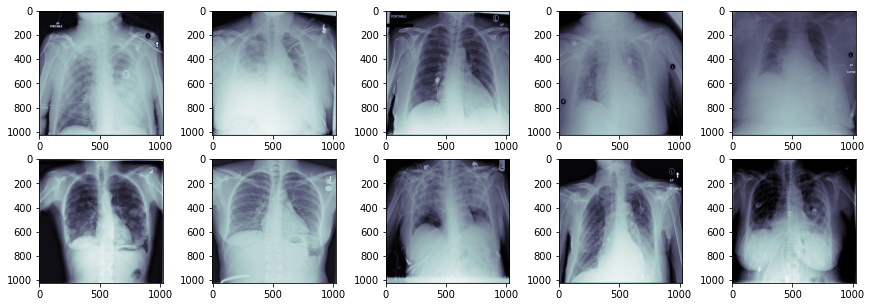

In [26]:
fig = plt.figure(figsize=(15,5))
cols = 5
rows = 2

for i in range(1, cols*rows + 1):
    dataset = pdm.dcmread(TRAIN_IMG_DIR + train_images[i])
    fig.add_subplot(rows, cols, i)
    plt.imshow(dataset.pixel_array, cmap=plt.cm.bone)

In [13]:
im = dataset.pixel_array

im.shape

(1024, 1024)

### `Meta` Data

In [12]:
dataset

Dataset.file_meta -------------------------------
(0002, 0000) File Meta Information Group Length  UL: 200
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: Secondary Capture Image Storage
(0002, 0003) Media Storage SOP Instance UID      UI: 1.2.276.0.7230010.3.1.4.8323329.3447.1517874302.81443
(0002, 0010) Transfer Syntax UID                 UI: JPEG Baseline (Process 1)
(0002, 0012) Implementation Class UID            UI: 1.2.276.0.7230010.3.0.3.6.0
(0002, 0013) Implementation Version Name         SH: 'OFFIS_DCMTK_360'
-------------------------------------------------
(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0016) SOP Class UID                       UI: Secondary Capture Image Storage
(0008, 0018) SOP Instance UID                    UI: 1.2.276.0.7230010.3.1.4.8323329.3447.1517874302.81443
(0008, 0020) Study Date                          DA: '19010101'
(0008, 0030) Study Time          

## B. `Label` Data

### `Label` Data: Load

In [28]:
train_labels = pd.read_csv(DATA_DIR + 'stage_2_train_labels.csv')
train_labels.head()

,patientId,x,y,width,height,Target
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1


In [30]:
class_info = pd.read_csv(DATA_DIR + 'stage_2_detailed_class_info.csv')
class_info.head()

,patientId,class
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,No Lung Opacity / Not Normal
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,No Lung Opacity / Not Normal
2,00322d4d-1c29-4943-afc9-b6754be640eb,No Lung Opacity / Not Normal
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,Normal
4,00436515-870c-4b36-a041-de91049b9ab4,Lung Opacity


### `Label` Data: Check Size

In [29]:
train_labels.shape #(30227,6)

(30227, 6)

In [31]:
class_info.shape #(30227,2)

(30227, 2)

### `Label` Data: Check N/A

In [42]:
# Check N/A in Bounding Box Labels
train_labels_op = train_labels[train_labels['Target'] == 1]

train_labels_op.x.isnull().sum(),\
train_labels_op.y.isnull().sum(),\
train_labels_op.width.isnull().sum(),\
train_labels_op.height.isnull().sum()

(0, 0, 0, 0)

In [41]:
# Check N/A in Class Labels
class_info['class'].isnull().sum()

0

### `Label` Data: Merge Dataframes by Index

In [43]:
list(train_labels['patientId']) == list(class_info['patientId'])

True

In [63]:
train_df = pd.DataFrame.merge(train_labels,class_info, left_index = True, right_index = True)
train_df = train_df.drop(['patientId_y'],axis = 1).rename(columns = {'patientId_x': 'patientId'}, inplace = False)

train_df.head()

,patientId,x,y,width,height,Target,class
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0,Normal
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1,Lung Opacity


In [59]:
train_df.shape

(30227, 7)

In [61]:
# Number of patientId should be the same as number of images in 'stage_2_train_images' folder
len(set(train_df['patientId'])),\
len(listdir(TRAIN_IMG_DIR))

(26684, 26684)

In [58]:
# In fact, <class 'Lung Opacity'> is equivalent to <Target '1'>
# expected output: (9555, 9555, 9555)

len(train_df[train_df['Target']==1]),\
len(train_df[train_df['class']=='Lung Opacity']),\
len(train_df[train_df['Target']==1][train_df[train_df['Target']==1]['class']=='Lung Opacity']) 

(9555, 9555, 9555)

In [25]:
train_df.to_csv (r'/home/jupyter/home/task1_rsna_pneumonia/saved_files/train_df.csv', index = False, header=True)

# II. Data Visualization (EDA)

## A. Lung Image of Specific Patient (Index)

In [65]:
DATA_INDEX = 123 # index number of label data that we want to check

In [72]:
image.shape

(1024, 1024)

,patientId,x,y,width,height,Target,class
123,03a9498c-549d-4e7d-800b-e74797f7f625,612.0,214.0,109.0,89.0,1,Lung Opacity


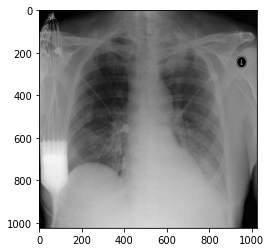

In [76]:
patient = train_df['patientId'][DATA_INDEX] 

image_path = TRAIN_IMG_DIR + patient + '.dcm'
image = pdm.dcmread(image_path).pixel_array

plt.imshow(image, cmap=plt.cm.gray)
plt.axis('on')

train_df.loc[[DATA_INDEX]]

### Lung Image: with Bounding Box

In [28]:
def bounding_box(image, patientId): #result = IMAGE
    patient_index = train_df.index[train_df['patientId'] == patientId].to_list()
    # 한 환자가 여러 개의 병변을 가질 경우 각 파트의 bounding box 정보가 다른 row에 들어있기 때문에,
    # 해당 환자의 dataframe내 index를 모두 뽑아낸다.

    for idx in patient_index:
        [x, y, w, h] = list(train_df[['x','y','width','height']].loc[idx])
        cv2.rectangle(image, (int(x),int(y)), (int(x+w),int(y+h)), (0,255,0), 4)

    return image

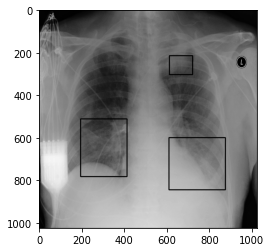

In [29]:
result = image.copy()
result_bb = bounding_box(result, patient)

plt.figure()
plt.imshow(result)
plt.imshow(result, cmap=plt.cm.gray)

## B. Images by classes

In [77]:
train_df[train_df['class'] == 'No Lung Opacity / Not Normal']['Target'].value_counts(dropna = False)

0    11821
Name: Target, dtype: int64

In [78]:
train_df[train_df['class'] == 'Normal']['Target'].value_counts(dropna = False)

0    8851
Name: Target, dtype: int64

In [79]:
train_df[train_df['class'] == 'Lung Opacity']['Target'].value_counts(dropna = False)

1    9555
Name: Target, dtype: int64

<AxesSubplot:xlabel='count', ylabel='Target'>

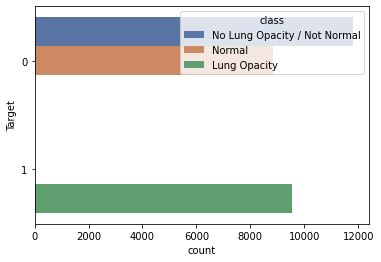

In [33]:
sns.countplot(y = train_df['Target'], hue = train_df['class'], palette='deep')

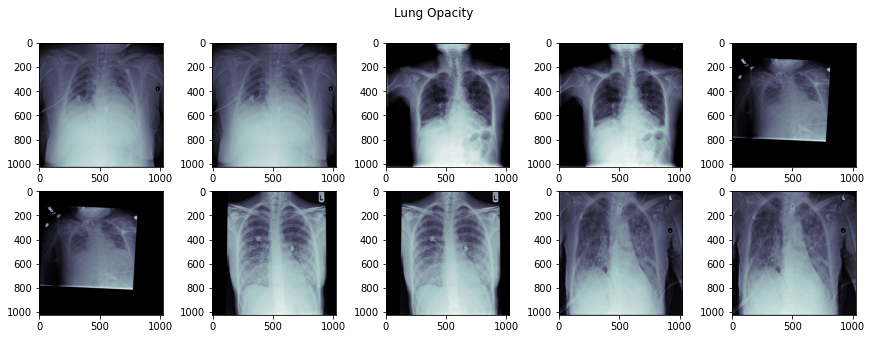

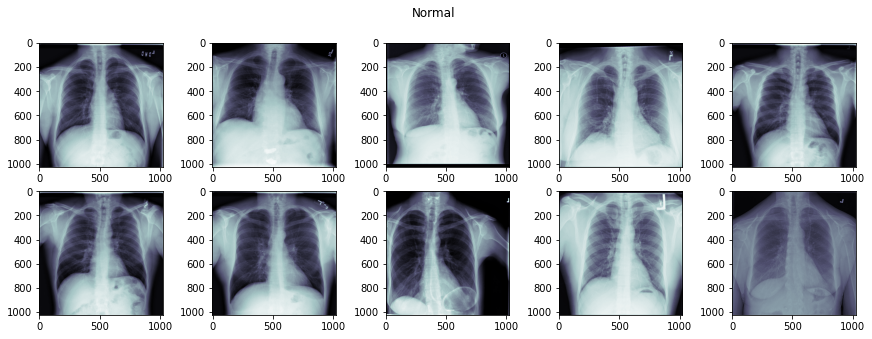

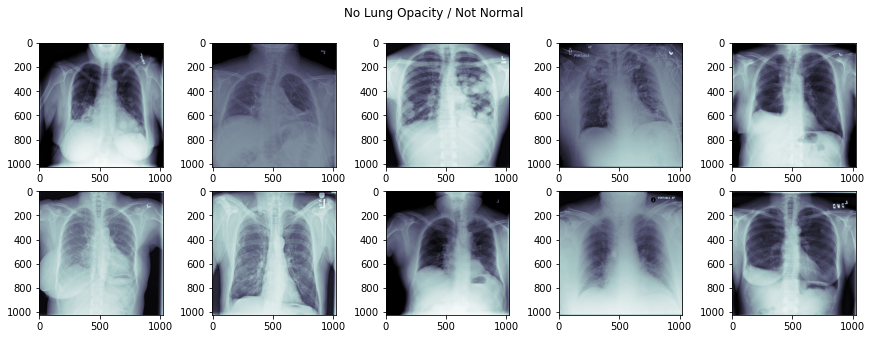

In [34]:
classes = list(set(train_df['class']))

for lungClass in classes:
    fig = plt.figure(figsize=(15,5))
    width = 5
    height = 2
    
    patients = list(train_df[train_df['class']==lungClass]['patientId'])

    for i, patientid in enumerate(patients[:width*height]):
        dataset = pdm.dcmread(TRAIN_IMG_DIR + patientid+'.dcm')
        fig.add_subplot(height, width, i + 1)
        plt.imshow(dataset.pixel_array, cmap=plt.cm.bone)

    plt.suptitle(lungClass)
    plt.show()

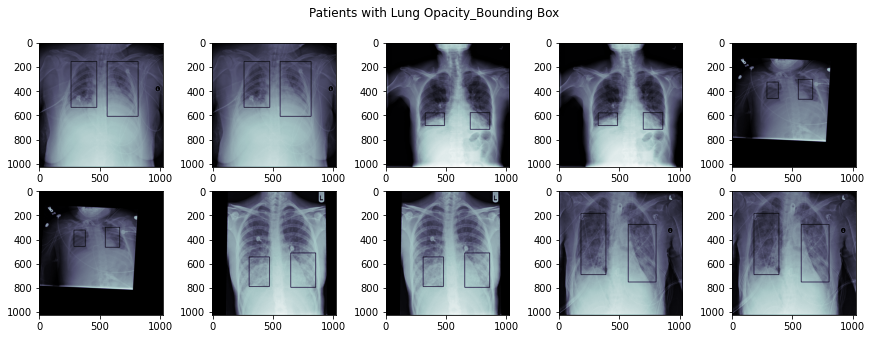

In [35]:
fig = plt.figure(figsize=(15,5))
width = 5
height = 2

patients = list(train_df[train_df['Target']==1]['patientId'])

for i, patientid in enumerate(patients[:width*height]):
    dataset = pdm.dcmread(TRAIN_IMG_DIR + patientid+'.dcm')
    fig.add_subplot(height, width, i + 1)
    plt.imshow(bounding_box(dataset.pixel_array, patientid), cmap=plt.cm.bone)
    
plt.suptitle("Patients with Lung Opacity_Bounding Box")
plt.show()

## C. Opacity Position / Size

In [36]:
# dataframe에서 lung opacity class에 해당되는 row만 추출
train_df_op = train_df[train_df['Target']==1]
train_df_op.head()

,patientId,x,y,width,height,Target,class
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1,Lung Opacity
5,00436515-870c-4b36-a041-de91049b9ab4,562.0,152.0,256.0,453.0,1,Lung Opacity
8,00704310-78a8-4b38-8475-49f4573b2dbb,323.0,577.0,160.0,104.0,1,Lung Opacity
9,00704310-78a8-4b38-8475-49f4573b2dbb,695.0,575.0,162.0,137.0,1,Lung Opacity
14,00aecb01-a116-45a2-956c-08d2fa55433f,288.0,322.0,94.0,135.0,1,Lung Opacity


<Figure size 432x288 with 0 Axes>

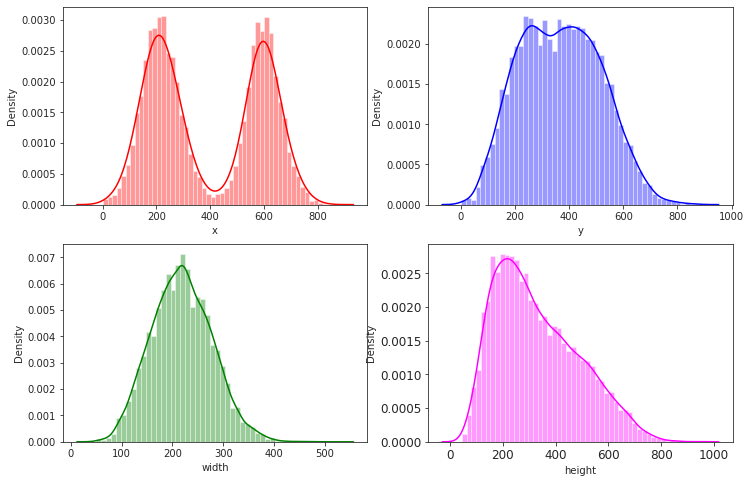

In [37]:
# bounding box의 위치와 사이즈 분포 확인

sns.set_style(style='ticks')
plt.figure()
fig, ax = plt.subplots(2,2,figsize=(12,8))
sns.distplot(train_df_op['x'],kde=True,bins=50, color="red", ax=ax[0,0])
sns.distplot(train_df_op['y'],kde=True,bins=50, color="blue", ax=ax[0,1])
sns.distplot(train_df_op['width'],kde=True,bins=50, color="green", ax=ax[1,0])
sns.distplot(train_df_op['height'],kde=True,bins=50, color="magenta", ax=ax[1,1])
locs, labels = plt.xticks()
plt.tick_params(axis='both', which='major', labelsize=12)
plt.show()

<Figure size 432x288 with 0 Axes>

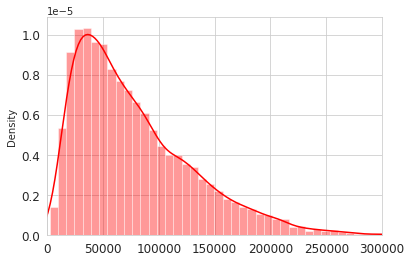

In [38]:
# area distribution 확인

width_lst = list(train_df_op['width'])
height_lst = list(train_df_op['height'])
size_lst = []

for idx in range(len(width_lst)):
    size = width_lst[idx] * height_lst[idx]
    size_lst.append(size)

sns.set_style('whitegrid')
plt.figure()
fig, ax = plt.subplots(figsize=(6,4))
sns.distplot(size_lst,kde=True,bins=50, color="red")
locs, labels = plt.xticks()
plt.tick_params(axis='both', which='major', labelsize=12)
plt.xlim(0, 300000)
plt.show()

In [39]:
df_areas = train_df_op[['x','y','width','height']].copy()
df_areas['x_2'] = df_areas['x'] + df_areas['width']
df_areas['y_2'] = df_areas['y'] + df_areas['height']
df_areas['x_center'] = df_areas['x'] + df_areas['width'] / 2
df_areas['y_center'] = df_areas['y'] + df_areas['height'] / 2
df_areas['area'] = df_areas['width'] * df_areas['height']

df_areas.head()

,x,y,width,height,x_2,y_2,x_center,y_center,area
4,264.0,152.0,213.0,379.0,477.0,531.0,370.5,341.5,80727.0
5,562.0,152.0,256.0,453.0,818.0,605.0,690.0,378.5,115968.0
8,323.0,577.0,160.0,104.0,483.0,681.0,403.0,629.0,16640.0
9,695.0,575.0,162.0,137.0,857.0,712.0,776.0,643.5,22194.0
14,288.0,322.0,94.0,135.0,382.0,457.0,335.0,389.5,12690.0


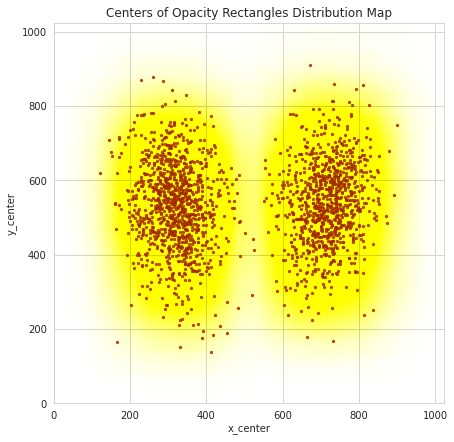

In [40]:
fig, ax = plt.subplots(1,1,figsize = (7,7))

plt.title("Centers of Opacity Rectangles Distribution Map")

df = df_areas[['x_center','y_center']].sample(2000)
df.plot.scatter(x = 'x_center', y = 'y_center', xlim = (0,1024), ylim = (0,1024),
                alpha = 0.8, ax=ax, marker = '.', color = 'brown')
for i, crt_sample in df.iterrows():
    ax.add_patch(Rectangle(xy=(df_areas['x'][i], df_areas['y'][i]), width = df_areas['width'][i],
                           height = df_areas['height'][i], alpha = 3.5e-3, color='yellow'))
plt.show()

## D. Numerical Analysis

In [41]:
print('Number of Patients with Lung Opacity: ', len(set(train_df[train_df['Target']==1]['patientId'])))
print('Number of Lung Opacity: ', len(train_df[train_df['Target']==1]))

Number of Patients with Lung Opacity:  6012
Number of Lung Opacity:  9555


## E. DICOM Meta Data

In [42]:
dataset

Dataset.file_meta -------------------------------
(0002, 0000) File Meta Information Group Length  UL: 200
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: Secondary Capture Image Storage
(0002, 0003) Media Storage SOP Instance UID      UI: 1.2.276.0.7230010.3.1.4.8323329.1556.1517874291.545552
(0002, 0010) Transfer Syntax UID                 UI: JPEG Baseline (Process 1)
(0002, 0012) Implementation Class UID            UI: 1.2.276.0.7230010.3.0.3.6.0
(0002, 0013) Implementation Version Name         SH: 'OFFIS_DCMTK_360'
-------------------------------------------------
(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0016) SOP Class UID                       UI: Secondary Capture Image Storage
(0008, 0018) SOP Instance UID                    UI: 1.2.276.0.7230010.3.1.4.8323329.1556.1517874291.545552
(0008, 0020) Study Date                          DA: '19010101'
(0008, 0030) Study Time        

In [43]:
train_meta_data_df = pd.DataFrame()
    
for idx, img in enumerate(train_images):
    img_path = TRAIN_IMG_DIR + img
    meta_data = pdm.read_file(img_path)
    
    train_meta_data_df.loc[idx, 'PatientID'] = meta_data.PatientID
    train_meta_data_df.loc[idx, 'PatientAge'] = meta_data.PatientAge
    train_meta_data_df.loc[idx, 'PatientSex'] = meta_data.PatientSex
    train_meta_data_df.loc[idx, 'Modality'] = meta_data.Modality
    train_meta_data_df.loc[idx, 'BodyPartExamined'] = meta_data.BodyPartExamined
    train_meta_data_df.loc[idx, 'ViewPosition'] = meta_data.ViewPosition
    train_meta_data_df.loc[idx, 'ConversionType'] = meta_data.ConversionType
    
    train_meta_data_df.loc[idx, 'ImagePath'] = img_path
        
train_meta_data_df

,PatientID,PatientAge,PatientSex,Modality,BodyPartExamined,ViewPosition,ConversionType,ImagePath
0,601eaa5d-3e4d-4d4c-b7df-600eb953554d,78,M,CR,CHEST,PA,WSD,/home/jupyter/home/task1_rsna_pneumonia/data/s...
1,31694f91-f16d-4d5c-9dac-b5c7dd5c767d,67,M,CR,CHEST,AP,WSD,/home/jupyter/home/task1_rsna_pneumonia/data/s...
2,cc3e8735-8a48-4704-a79e-a253677ee5f9,48,F,CR,CHEST,AP,WSD,/home/jupyter/home/task1_rsna_pneumonia/data/s...
3,4399092c-0489-4ec7-97a5-fbffd3da0ea6,71,F,CR,CHEST,AP,WSD,/home/jupyter/home/task1_rsna_pneumonia/data/s...
4,6c6483ba-b672-402d-8d8a-10452b1e1387,32,F,CR,CHEST,AP,WSD,/home/jupyter/home/task1_rsna_pneumonia/data/s...
...,...,...,...,...,...,...,...,...
26679,13932109-fbd1-4b6b-b81c-91682740cc50,24,M,CR,CHEST,AP,WSD,/home/jupyter/home/task1_rsna_pneumonia/data/s...
26680,cecd4a1a-f4eb-4eef-adc7-6ab571c803d7,32,M,CR,CHEST,AP,WSD,/home/jupyter/home/task1_rsna_pneumonia/data/s...
26681,1863f91d-3b5e-413d-a0ac-f97a7c006334,66,F,CR,CHEST,AP,WSD,/home/jupyter/home/task1_rsna_pneumonia/data/s...
26682,f0e0da1c-1f11-4a28-bcce-1509c528715a,20,M,CR,CHEST,PA,WSD,/home/jupyter/home/task1_rsna_pneumonia/data/s...


In [44]:
test_meta_data_df = pd.DataFrame()
    
for idx, img in enumerate(test_images):
    img_path = TEST_IMG_DIR + img
    meta_data = pdm.read_file(img_path)
    
    test_meta_data_df.loc[idx, 'PatientID'] = meta_data.PatientID
    test_meta_data_df.loc[idx, 'PatientAge'] = meta_data.PatientAge
    test_meta_data_df.loc[idx, 'PatientSex'] = meta_data.PatientSex
    test_meta_data_df.loc[idx, 'Modality'] = meta_data.Modality
    test_meta_data_df.loc[idx, 'BodyPartExamined'] = meta_data.BodyPartExamined
    test_meta_data_df.loc[idx, 'ViewPosition'] = meta_data.ViewPosition
    test_meta_data_df.loc[idx, 'ConversionType'] = meta_data.ConversionType
    
    test_meta_data_df.loc[idx, 'ImagePath'] = img_path
        
test_meta_data_df

,PatientID,PatientAge,PatientSex,Modality,BodyPartExamined,ViewPosition,ConversionType,ImagePath
0,0cef9e32-622e-4703-80e1-c14460e9f716,22,F,CR,CHEST,AP,WSD,/home/jupyter/home/task1_rsna_pneumonia/data/s...
1,2e34e10c-62b2-48b0-bd44-ccb690b3f461,57,F,CR,CHEST,PA,WSD,/home/jupyter/home/task1_rsna_pneumonia/data/s...
2,032b9367-1ce3-44e8-9b74-8f3e2203e8ec,66,F,CR,CHEST,PA,WSD,/home/jupyter/home/task1_rsna_pneumonia/data/s...
3,0483d8c8-2d15-4ae0-8034-4dca932e8ddd,65,M,CR,CHEST,AP,WSD,/home/jupyter/home/task1_rsna_pneumonia/data/s...
4,20f7fda5-8ccf-42c8-b87e-89b78e35366e,15,F,CR,CHEST,AP,WSD,/home/jupyter/home/task1_rsna_pneumonia/data/s...
...,...,...,...,...,...,...,...,...
2995,c1d9b4c9-39cc-4b37-b95b-82d26a1b68df,44,F,CR,CHEST,PA,WSD,/home/jupyter/home/task1_rsna_pneumonia/data/s...
2996,30fe50ee-4108-42fe-8dfd-27b1e61dccf0,57,M,CR,CHEST,AP,WSD,/home/jupyter/home/task1_rsna_pneumonia/data/s...
2997,28a52994-65a7-4fe6-aa5e-adc0fd4535e9,32,F,CR,CHEST,AP,WSD,/home/jupyter/home/task1_rsna_pneumonia/data/s...
2998,20f38c57-8a12-493d-90ab-4c6c7f0798ba,46,F,CR,CHEST,PA,WSD,/home/jupyter/home/task1_rsna_pneumonia/data/s...


In [45]:
#https://www.kaggle.com/gpreda/rsna-pneumonia-detection-eda

def get_feature_distribution(data, feature):
    # Get the count for each label
    label_counts = data[feature].value_counts()

    # Get total number of samples
    total_samples = len(data)

    # Count the number of items in each class
    print("Feature: {}".format(feature))
    for i in range(len(label_counts)):
        label = label_counts.index[i]
        count = label_counts.values[i]
        percent = int((count / total_samples) * 10000) / 100
        print("{:<30s}:   {} or {}%".format(label, count, percent))

In [46]:
print(train_meta_data_df['PatientSex'].isnull().sum())
print(train_meta_data_df['Modality'].isnull().sum())
print(train_meta_data_df['BodyPartExamined'].isnull().sum())
print(train_meta_data_df['ViewPosition'].isnull().sum())
print(train_meta_data_df['ConversionType'].isnull().sum())

0
0
0
0
0


In [47]:
get_feature_distribution(train_meta_data_df,'PatientSex')
get_feature_distribution(train_meta_data_df,'Modality')
get_feature_distribution(train_meta_data_df,'BodyPartExamined')
get_feature_distribution(train_meta_data_df,'ViewPosition')
get_feature_distribution(train_meta_data_df,'ConversionType')

Feature: PatientSex
M                             :   15166 or 56.83%
F                             :   11518 or 43.16%
Feature: Modality
CR                            :   26684 or 100.0%
Feature: BodyPartExamined
CHEST                         :   26684 or 100.0%
Feature: ViewPosition
PA                            :   14511 or 54.38%
AP                            :   12173 or 45.61%
Feature: ConversionType
WSD                           :   26684 or 100.0%


In [48]:
get_feature_distribution(test_meta_data_df,'PatientSex')
get_feature_distribution(test_meta_data_df,'Modality')
get_feature_distribution(test_meta_data_df,'BodyPartExamined')
get_feature_distribution(test_meta_data_df,'ViewPosition')
get_feature_distribution(test_meta_data_df,'ConversionType')

Feature: PatientSex
M                             :   1714 or 57.13%
F                             :   1286 or 42.86%
Feature: Modality
CR                            :   3000 or 100.0%
Feature: BodyPartExamined
CHEST                         :   3000 or 100.0%
Feature: ViewPosition
PA                            :   1618 or 53.93%
AP                            :   1382 or 46.06%
Feature: ConversionType
WSD                           :   3000 or 100.0%


<Figure size 432x288 with 0 Axes>

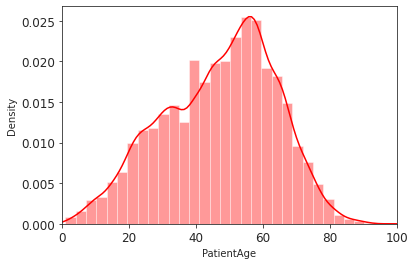

In [49]:
sns.set_style(style='ticks')
plt.figure()
fig, ax = plt.subplots(1,1,figsize=(6,4))
sns.distplot(train_meta_data_df['PatientAge'],kde=True,bins=50, color="red", ax=ax)
locs, labels = plt.xticks()
plt.tick_params(axis='both', which='major', labelsize=12)
plt.xlim(0, 100)
plt.show()

<Figure size 432x288 with 0 Axes>

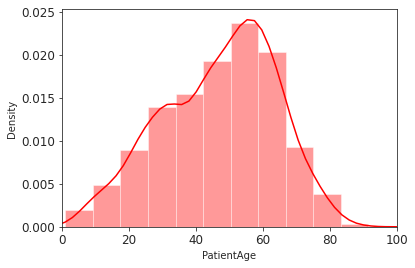

In [50]:
sns.set_style(style='ticks')
plt.figure()
fig, ax = plt.subplots(1,1,figsize=(6,4))
sns.distplot(test_meta_data_df['PatientAge'],kde=True, bins=50, color="red", ax=ax)
locs, labels = plt.xticks()
plt.tick_params(axis='both', which='major', labelsize=12)
plt.xlim(0, 100)
plt.show()

In [51]:
train_meta_data_df

,PatientID,PatientAge,PatientSex,Modality,BodyPartExamined,ViewPosition,ConversionType,ImagePath
0,601eaa5d-3e4d-4d4c-b7df-600eb953554d,78,M,CR,CHEST,PA,WSD,/home/jupyter/home/task1_rsna_pneumonia/data/s...
1,31694f91-f16d-4d5c-9dac-b5c7dd5c767d,67,M,CR,CHEST,AP,WSD,/home/jupyter/home/task1_rsna_pneumonia/data/s...
2,cc3e8735-8a48-4704-a79e-a253677ee5f9,48,F,CR,CHEST,AP,WSD,/home/jupyter/home/task1_rsna_pneumonia/data/s...
3,4399092c-0489-4ec7-97a5-fbffd3da0ea6,71,F,CR,CHEST,AP,WSD,/home/jupyter/home/task1_rsna_pneumonia/data/s...
4,6c6483ba-b672-402d-8d8a-10452b1e1387,32,F,CR,CHEST,AP,WSD,/home/jupyter/home/task1_rsna_pneumonia/data/s...
...,...,...,...,...,...,...,...,...
26679,13932109-fbd1-4b6b-b81c-91682740cc50,24,M,CR,CHEST,AP,WSD,/home/jupyter/home/task1_rsna_pneumonia/data/s...
26680,cecd4a1a-f4eb-4eef-adc7-6ab571c803d7,32,M,CR,CHEST,AP,WSD,/home/jupyter/home/task1_rsna_pneumonia/data/s...
26681,1863f91d-3b5e-413d-a0ac-f97a7c006334,66,F,CR,CHEST,AP,WSD,/home/jupyter/home/task1_rsna_pneumonia/data/s...
26682,f0e0da1c-1f11-4a28-bcce-1509c528715a,20,M,CR,CHEST,PA,WSD,/home/jupyter/home/task1_rsna_pneumonia/data/s...


In [52]:
train_meta_data_df = train_meta_data_df[['PatientID','PatientAge','PatientSex','ViewPosition','ImagePath']]
train_meta_data_df.head()

,PatientID,PatientAge,PatientSex,ViewPosition,ImagePath
0,601eaa5d-3e4d-4d4c-b7df-600eb953554d,78,M,PA,/home/jupyter/home/task1_rsna_pneumonia/data/s...
1,31694f91-f16d-4d5c-9dac-b5c7dd5c767d,67,M,AP,/home/jupyter/home/task1_rsna_pneumonia/data/s...
2,cc3e8735-8a48-4704-a79e-a253677ee5f9,48,F,AP,/home/jupyter/home/task1_rsna_pneumonia/data/s...
3,4399092c-0489-4ec7-97a5-fbffd3da0ea6,71,F,AP,/home/jupyter/home/task1_rsna_pneumonia/data/s...
4,6c6483ba-b672-402d-8d8a-10452b1e1387,32,F,AP,/home/jupyter/home/task1_rsna_pneumonia/data/s...


In [53]:
test_meta_data_df = test_meta_data_df[['PatientID','PatientAge','PatientSex','ViewPosition','ImagePath']]
test_meta_data_df.head()

,PatientID,PatientAge,PatientSex,ViewPosition,ImagePath
0,0cef9e32-622e-4703-80e1-c14460e9f716,22,F,AP,/home/jupyter/home/task1_rsna_pneumonia/data/s...
1,2e34e10c-62b2-48b0-bd44-ccb690b3f461,57,F,PA,/home/jupyter/home/task1_rsna_pneumonia/data/s...
2,032b9367-1ce3-44e8-9b74-8f3e2203e8ec,66,F,PA,/home/jupyter/home/task1_rsna_pneumonia/data/s...
3,0483d8c8-2d15-4ae0-8034-4dca932e8ddd,65,M,AP,/home/jupyter/home/task1_rsna_pneumonia/data/s...
4,20f7fda5-8ccf-42c8-b87e-89b78e35366e,15,F,AP,/home/jupyter/home/task1_rsna_pneumonia/data/s...


In [55]:
train_meta_data_df.to_csv (r'/home/jupyter/home/task1_rsna_pneumonia/saved_files/train_meta_data_df.csv', index = False, header=True)

In [56]:
test_meta_data_df.to_csv (r'/home/jupyter/home/task1_rsna_pneumonia/saved_files/test_meta_data_df.csv', index = False, header=True)

In [81]:
train_df.head()

,patientId,x,y,width,height,Target,class
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0,Normal
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1,Lung Opacity
